In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [34]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import tqdm

In [3]:
# Create a simple LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_rate=0.2):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out[:, -1, :])  # Take only the output of the last time step
        out = self.fc(out)
        return out


In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [4]:
# Prepare data for training
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        target = data[i+seq_length:i+seq_length+1]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

In [35]:
df = pd.read_csv('../data/MNQ DEC23.Last-500-Volume-Action.txt')
df.head()

,date,open,high,low,close,vol,ft,action
0,2023-10-02 22:00:38,14992.00,14992.25,14986.50,14989.50,500,-0.342828,0
1,2023-10-02 22:03:41,14989.75,14992.50,14988.25,14990.50,500,-0.062081,0
2,2023-10-02 22:08:04,14991.00,14992.75,14989.50,14992.00,500,0.396141,0
3,2023-10-02 22:13:26,14992.00,14995.00,14987.75,14989.75,500,0.204056,0
4,2023-10-02 22:14:44,14989.75,14999.00,14989.75,14997.50,500,0.449363,0


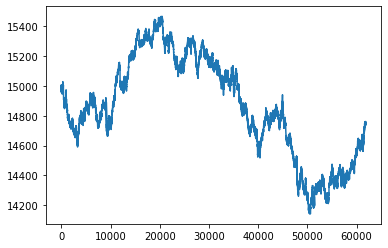

In [36]:
plt.plot(df['close'])
plt.show()

In [37]:
df.shape

(61833, 8)

In [38]:
# Preprocess the data
scaler = StandardScaler()
scaler = MinMaxScaler()
prices_scaled = scaler.fit_transform(df[['close']].values)

In [39]:
seq_length = 52
X, y = create_sequences(prices_scaled, seq_length)

# Convert to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

In [9]:
y.shape

torch.Size([61781, 1, 1])

In [10]:
y[1]

tensor([[0.3197]])

In [11]:
y[0]=df['close'].values[53]

In [12]:
df['close'].values[0:52+0]

array([14989.5 , 14990.5 , 14992.  , 14989.75, 14997.5 , 14996.  ,
       15001.  , 15002.75, 15007.75, 15002.25, 14998.  , 14994.25,
       14993.5 , 14995.  , 14990.5 , 14988.25, 14994.  , 14992.25,
       14990.5 , 14987.25, 14987.5 , 14981.75, 14982.25, 14980.5 ,
       14981.  , 14986.25, 14991.25, 14991.  , 14994.5 , 15001.  ,
       14998.25, 14996.75, 14992.75, 14988.75, 14985.  , 14986.75,
       14982.75, 14978.75, 14978.25, 14974.75, 14969.75, 14970.  ,
       14965.25, 14963.  , 14960.  , 14956.5 , 14960.5 , 14963.75,
       14960.  , 14957.75, 14962.  , 14966.25])

In [13]:
x[1][-1]

NameError: name 'x' is not defined

In [14]:
df['close'].values[0+1:52+1]

array([14990.5 , 14992.  , 14989.75, 14997.5 , 14996.  , 15001.  ,
       15002.75, 15007.75, 15002.25, 14998.  , 14994.25, 14993.5 ,
       14995.  , 14990.5 , 14988.25, 14994.  , 14992.25, 14990.5 ,
       14987.25, 14987.5 , 14981.75, 14982.25, 14980.5 , 14981.  ,
       14986.25, 14991.25, 14991.  , 14994.5 , 15001.  , 14998.25,
       14996.75, 14992.75, 14988.75, 14985.  , 14986.75, 14982.75,
       14978.75, 14978.25, 14974.75, 14969.75, 14970.  , 14965.25,
       14963.  , 14960.  , 14956.5 , 14960.5 , 14963.75, 14960.  ,
       14957.75, 14962.  , 14966.25, 14963.  ])

In [10]:
# Configure device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
weight = np.ones(seq_length)/np.array(range(1,seq_length+1))
weight = torch.FloatTensor(weight).to(device)
weight

In [ ]:
plt.plot(weight.to('cpu'))

In [ ]:

class weighted_MSELoss(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self,inputs,targets,weights):
        return ((input - target)**2 ) * weight


weight=torch.FloatTensor([2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1])

mse_criterion = weighted_MSELoss()
loss_mot_rec = mse_criterion(self.fake_noise,self.real_noise,weights).mean(dim = -1)

def weighted_mse_loss(input, target):
    
    return (weight * (input - target) ** 2)


In [15]:
?LSTM

train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

for idx, (batch_X, batch_y) in enumerate(train_loader):
    print(idx)
    print(batch_X.shape)
    break

batch_X[0].reshape(-1),batch_X[1].reshape(-1)

In [103]:
# Hyperparameters
input_size = 1 # number of features
hidden_size = 256 #
num_layers = 2
output_size = 1
num_epochs = 50
learning_rate = 0.1
batch_size = 128

# Initialize model, loss function, and optimizer
model = LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, output_size=output_size)
model.to(device)

# https://discuss.pytorch.org/t/how-to-implement-weighted-mean-square-error/2547/6
criterion = nn.MSELoss() # <<<
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

In [42]:
for idx, (train_index, test_index) in enumerate(tqdm.tqdm_notebook(tscv.split(X))):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    break

Epoch [10/50], Loss: 0.0040
Epoch [20/50], Loss: 0.0040
Epoch [30/50], Loss: 0.0163
Epoch [40/50], Loss: 0.0094
Epoch [50/50], Loss: 0.0103


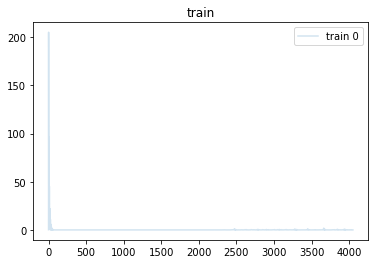

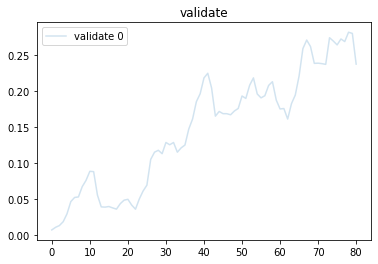

Epoch [10/50], Loss: 0.0425
Epoch [20/50], Loss: 0.6239
Epoch [30/50], Loss: 0.3474
Epoch [40/50], Loss: 0.0709
Epoch [50/50], Loss: 0.1642


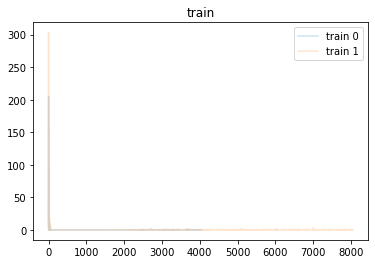

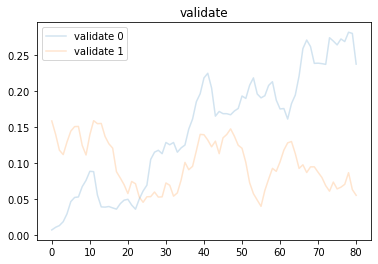

Epoch [10/50], Loss: 0.1748
Epoch [20/50], Loss: 0.0511
Epoch [30/50], Loss: 0.3135
Epoch [40/50], Loss: 0.0769
Epoch [50/50], Loss: 0.0447


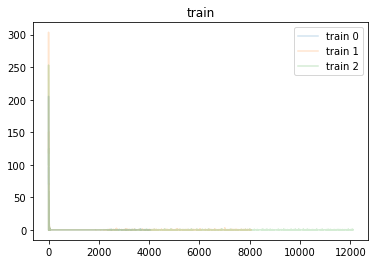

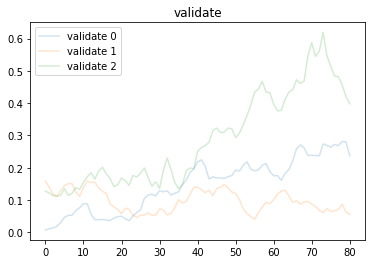

Epoch [10/50], Loss: 0.0761
Epoch [20/50], Loss: 0.0602
Epoch [30/50], Loss: 0.1660
Epoch [40/50], Loss: 0.1396


In [ ]:
losses = []
losses_after = []
# Training loop

# N split cross validation
for idx, (train_index, test_index) in enumerate(tqdm.tqdm_notebook(tscv.split(X))):
    
    model = LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, output_size=output_size)
    model.to(device)

    # https://discuss.pytorch.org/t/how-to-implement-weighted-mean-square-error/2547/6
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    model.train()
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Convert to DataLoader for easy batching
    train_data = torch.utils.data.TensorDataset(X_train, y_train)
    train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

    for epoch in tqdm.tqdm_notebook(range(num_epochs), leave=False):
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            # Backward and optimize
            optimizer.zero_grad()
            # Forward pass
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            loss_after = criterion(outputs, batch_y)
            losses_after.append([loss_after.item(), 0, idx])
            losses.append([loss.item(), 0, idx])

        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    model.eval()
    with torch.no_grad():
        test_data = torch.utils.data.TensorDataset(X_test, y_test)
        test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

        predictions = []
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            # predictions.extend(outputs.cpu().numpy())
            loss = criterion(outputs, batch_y)
#             print(loss.item())
            losses.append([loss.item(), 1,idx])

    model.train()

    for iidx in range(idx+1):
        plt.plot(list(map(lambda x: x[0],filter(lambda x: (x[2]==iidx) &(x[1]==0), losses) )),
                 label=f'train {iidx}', alpha=0.2)
    plt.legend()
    plt.title(f'train')
    plt.show()

    for iidx in range(idx+1):
        plt.plot(list(map(lambda x: x[0],filter(lambda x: (x[2]==iidx) &(x[1]==1), losses) )),
                    label=f'validate {iidx}', alpha=0.2)
    plt.legend()
    plt.title(f'validate')
    plt.show()
#     break


In [87]:
for batch_X, batch_y in test_loader:
    batch_X, batch_y = batch_X.to(device), batch_y.to(device)
    outputs = model(batch_X)
    # predictions.extend(outputs.cpu().numpy())
    loss = criterion(outputs, batch_y)
    break
#             print(loss.item())

#     losses.append([loss.item(), 1,idx])

In [88]:
outputs.shape

torch.Size([256, 1])

In [89]:
local_loss = []
for idx in range(128):
    local_loss.append([batch_y[idx].to('cpu').reshape((-1,)).detach().numpy()[0], outputs[idx].to('cpu').detach().numpy()[0]])

In [90]:
u = np.array(local_loss)
_yhat = u[::,0]
_y = u[::,1]

In [91]:
loss

tensor(0.0025, device='cuda:0', grad_fn=<MseLossBackward>)

In [92]:
((_yhat-_y)**2).mean()

0.0017349893

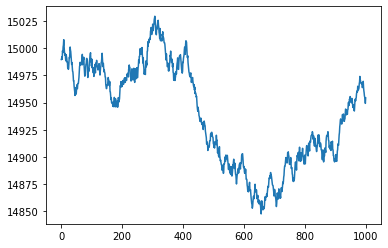

In [93]:
plt.plot(df['close'].values[:1000])

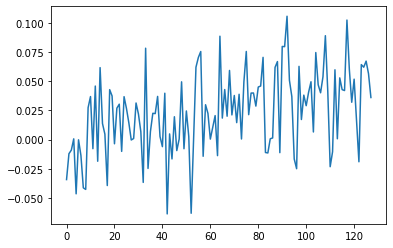

In [94]:
plt.plot(_yhat-_y)
plt.show()

In [95]:
outputs.reshape((-1,))

tensor([0.5479, 0.5254, 0.5240, 0.5138, 0.5586, 0.5124, 0.5248, 0.5576, 0.5567,
        0.4877, 0.4780, 0.5251, 0.4675, 0.5323, 0.4531, 0.5022, 0.5130, 0.5585,
        0.4764, 0.4792, 0.5209, 0.4929, 0.4909, 0.5343, 0.4885, 0.4997, 0.5111,
        0.5250, 0.5235, 0.4920, 0.5012, 0.5149, 0.5579, 0.4432, 0.5440, 0.5125,
        0.4991, 0.4999, 0.4790, 0.5126, 0.5235, 0.4772, 0.5803, 0.5120, 0.5346,
        0.5019, 0.5344, 0.5258, 0.4797, 0.5347, 0.5014, 0.5251, 0.5911, 0.5259,
        0.4667, 0.4589, 0.4528, 0.5466, 0.5001, 0.5110, 0.5342, 0.5232, 0.5145,
        0.5466, 0.4454, 0.5143, 0.4895, 0.5140, 0.4777, 0.5144, 0.4995, 0.5244,
        0.5019, 0.5365, 0.4890, 0.4656, 0.5219, 0.5023, 0.5008, 0.5140, 0.5021,
        0.5012, 0.4767, 0.5583, 0.5575, 0.5471, 0.5473, 0.4873, 0.4803, 0.5577,
        0.4685, 0.4696, 0.4454, 0.4991, 0.5134, 0.5693, 0.5804, 0.4915, 0.5361,
        0.5130, 0.5214, 0.5128, 0.5017, 0.5449, 0.4750, 0.5011, 0.5123, 0.4994,
        0.4672, 0.5132, 0.5799, 0.5688, 

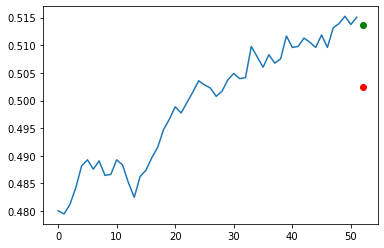

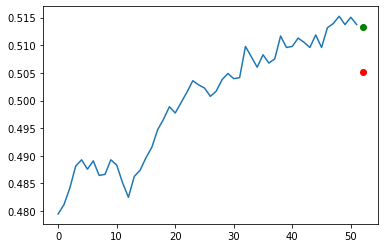

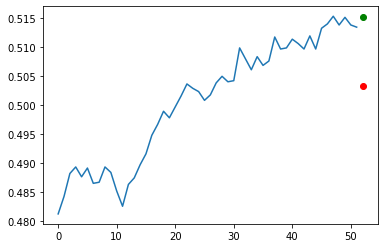

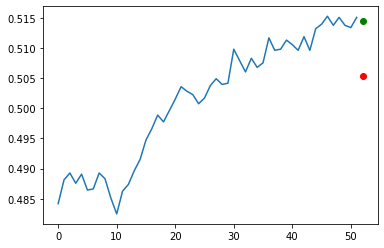

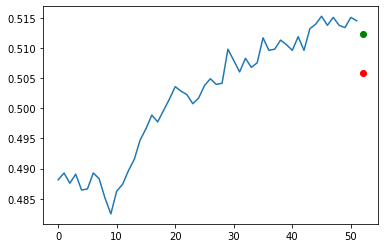

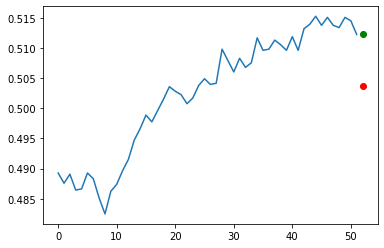

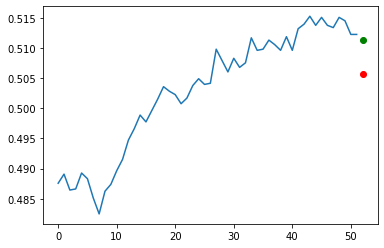

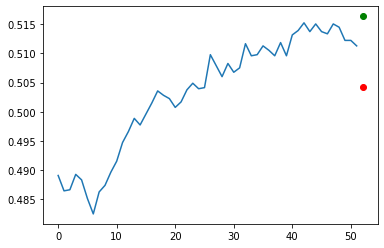

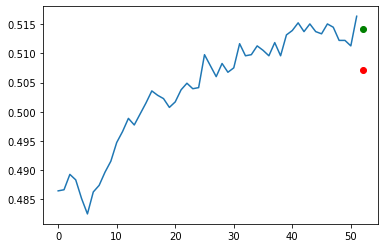

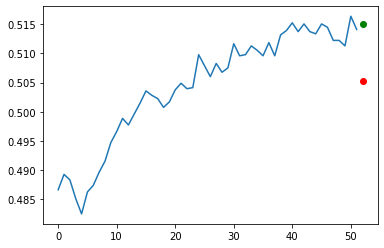

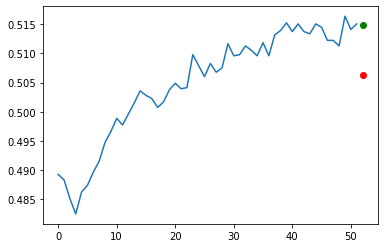

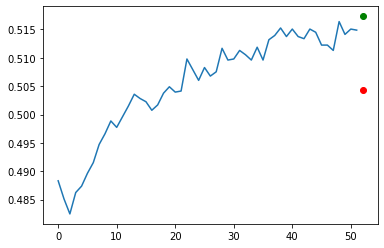

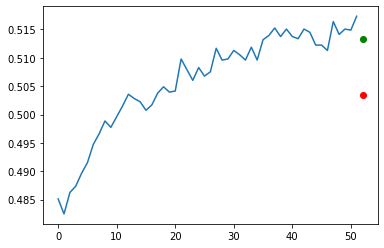

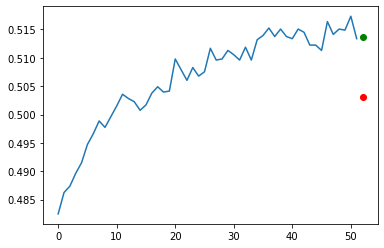

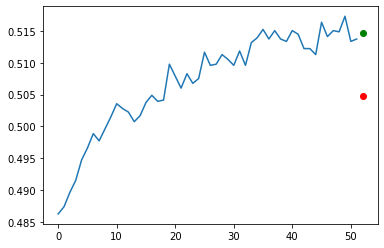

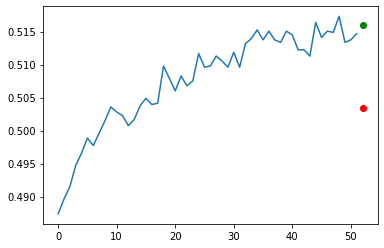

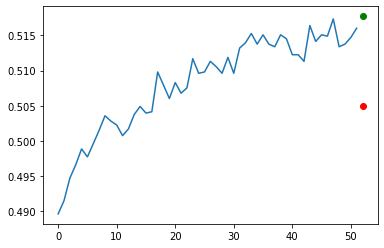

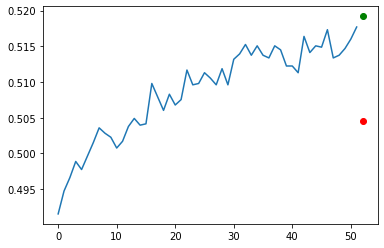

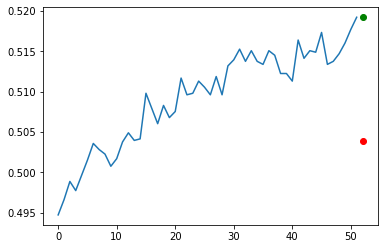

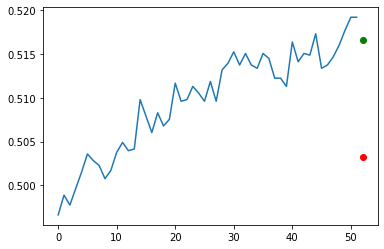

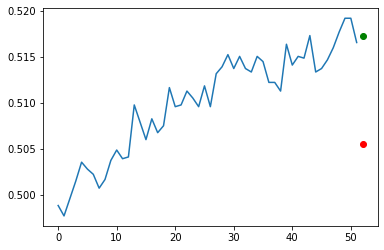

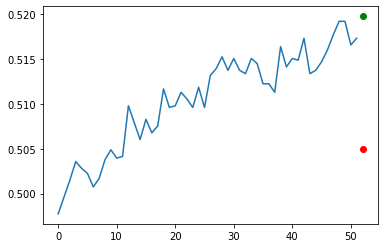

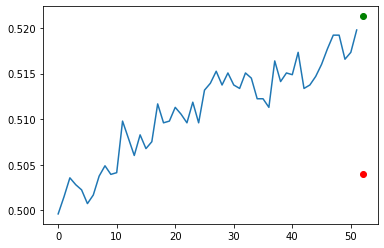

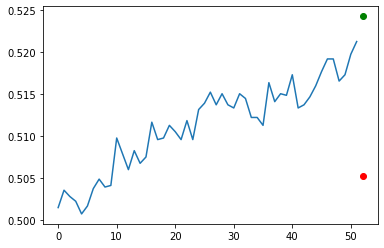

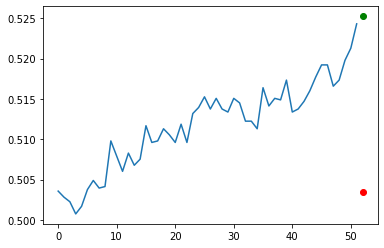

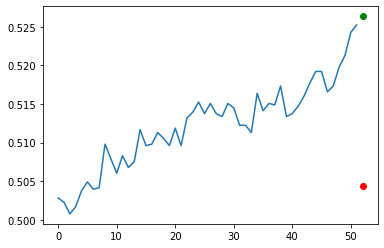

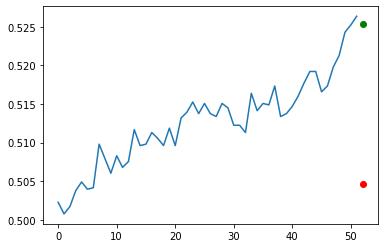

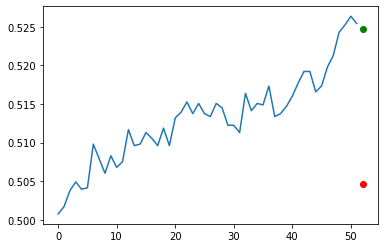

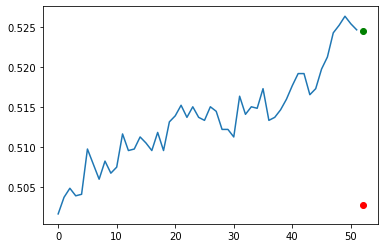

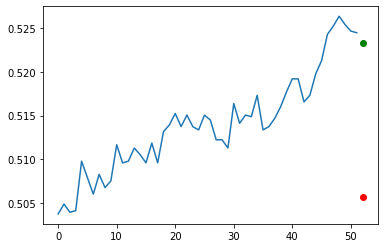

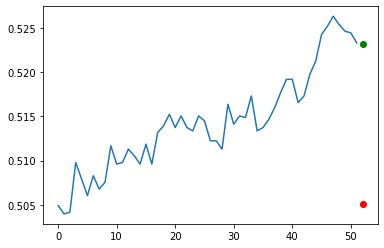

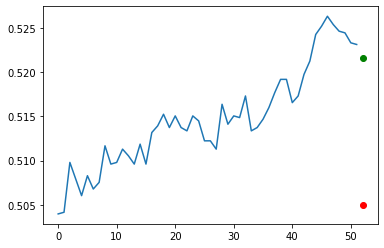

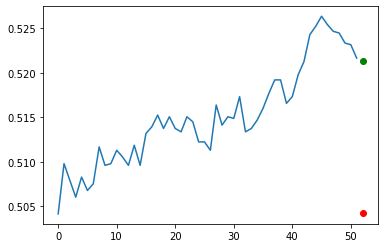

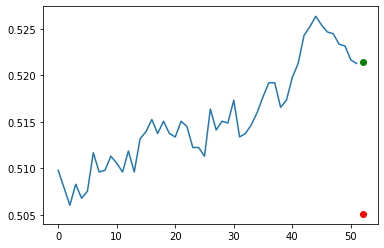

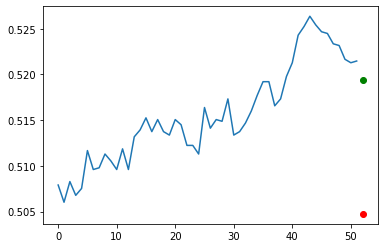

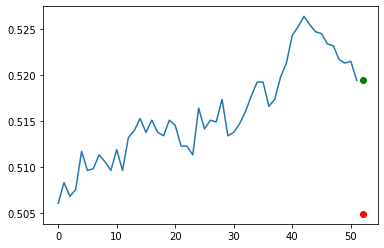

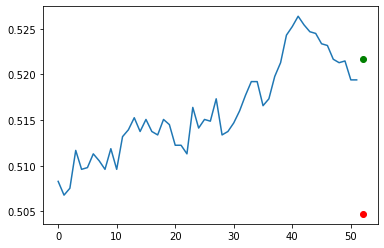

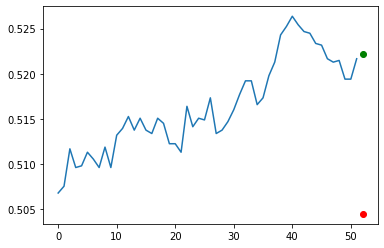

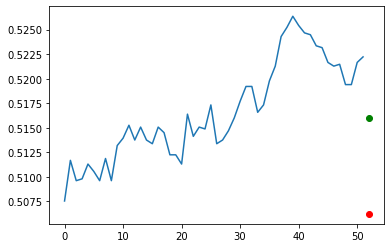

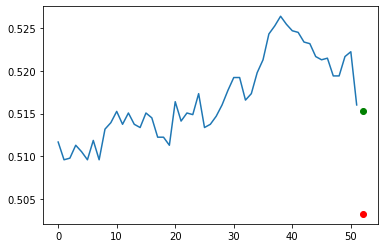

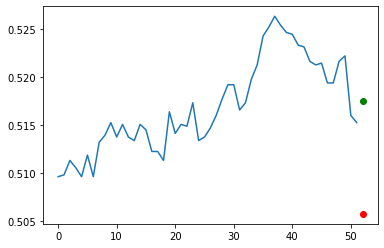

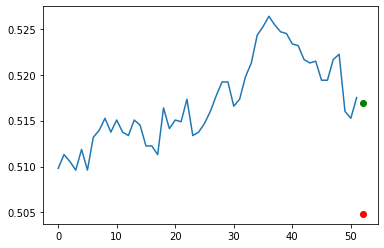

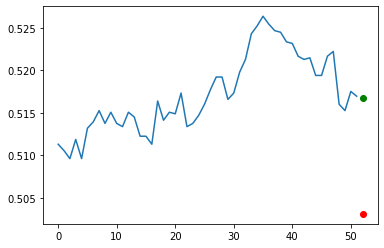

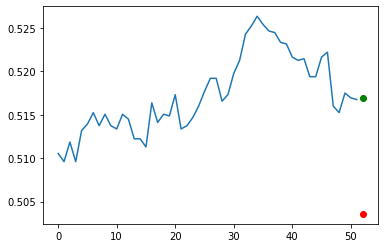

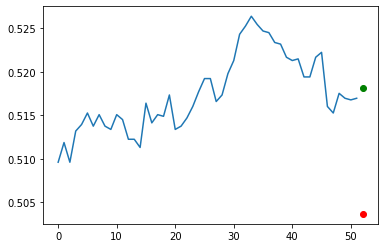

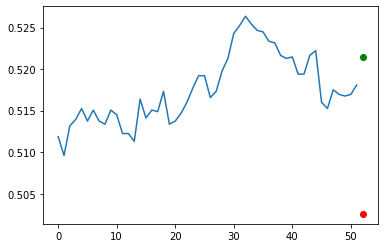

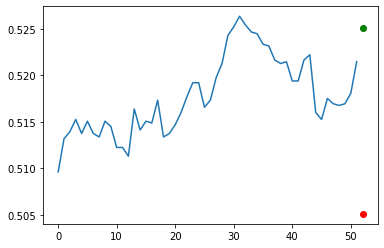

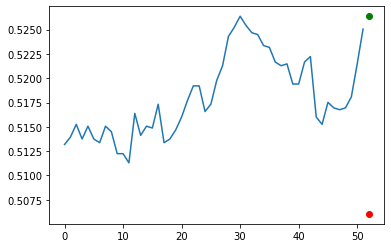

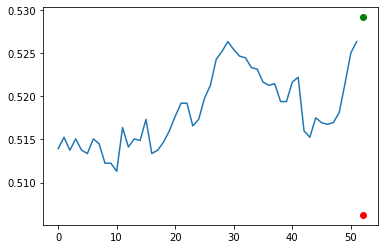

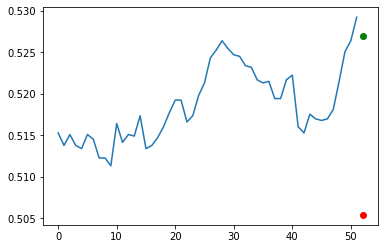

In [82]:
for idx in range(50):
    plt.plot(batch_X[idx].to('cpu').reshape((-1,)))
    plt.scatter(52,batch_y[idx].to('cpu').reshape((-1,)), color='green')
    plt.scatter(52, outputs[idx].to('cpu').detach().numpy(), color='red')
    plt.show()

In [45]:
loss

tensor(0.0012, device='cuda:0', grad_fn=<MseLossBackward>)

In [30]:
list(range(1))

[0]

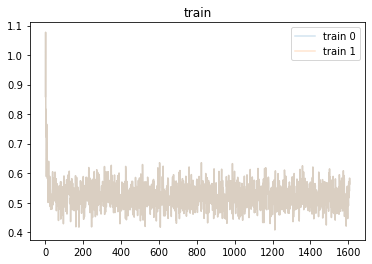

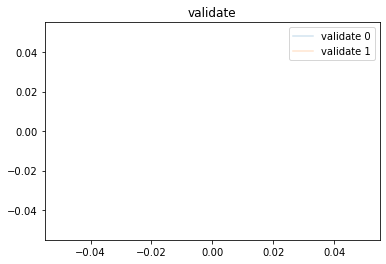

In [28]:
for iidx in range(idx+1):
    plt.plot(list(map(lambda x: x[0],filter(lambda x: (x[2]==idx) &(x[1]==0), losses) )),
             label=f'train {iidx}', alpha=0.2)
plt.legend()
plt.title(f'train')
plt.show()

for iidx in range(idx+1):
    plt.plot(list(map(lambda x: x[0],filter(lambda x: (x[2]==idx) &(x[1]==1), losses) )),
             label=f'validate {iidx}', alpha=0.2)
plt.legend()
plt.title(f'validate')
plt.show()

In [21]:
?filter

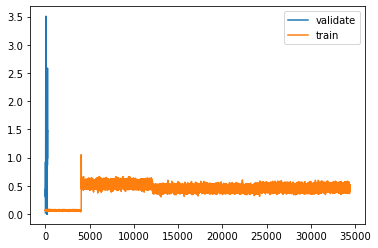

In [15]:
# Inverse transform the predictions
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test)
y_test = y_test.reshape((-1,1))

In [16]:
predictions

array([[14936.91 ],
       [14936.902],
       [14936.916],
       ...,
       [14940.347],
       [14940.351],
       [14940.35 ]], dtype=float32)

In [17]:
y_test

array([[14296.25],
       [14302.  ],
       [14303.75],
       ...,
       [14756.  ],
       [14755.75],
       [14760.  ]], dtype=float32)

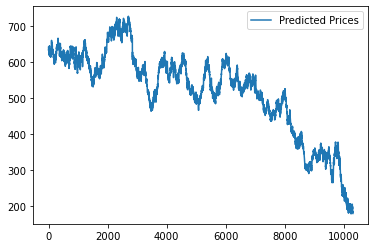

In [18]:
plt.plot((predictions - y_test).reshape((-1,)), label='Predicted Prices')
plt.legend()
plt.show()

Mean Squared Error on Test Data: 282789.2500


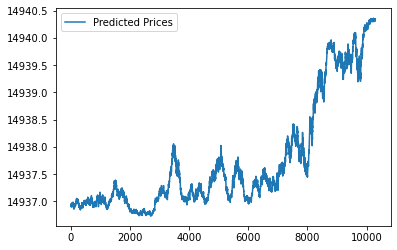

In [22]:
# Calculate and print the Mean Squared Error
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error on Test Data: {mse:.4f}')

# Plot the results
# plt.plot(y_test.reshape((-1,)), label='True Prices')
plt.plot(predictions.reshape((-1,)), label='Predicted Prices')
plt.legend()
plt.show()

Mean Squared Error on Test Data: 282789.2500


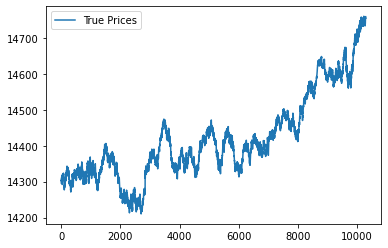

In [20]:
# Calculate and print the Mean Squared Error
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error on Test Data: {mse:.4f}')

# Plot the results
plt.plot(y_test.reshape((-1,)), label='True Prices')
# plt.plot(predictions.reshape((-1,)), label='Predicted Prices')
plt.legend()
plt.show()